In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('WDI_csv/WDIData.csv',index_col='Country Name')
df = df.iloc[:, :-1]
print(df.shape)

(25038, 61)


In [3]:
set(df.loc['Afghanistan']['Indicator Name'])

{'5-bank asset concentration',
 'ATMs per 100,000 adults',
 'Account at a formal financial institution (% age 15+)',
 'Account used for business purposes (% age 15+)',
 'Account used to receive government payments (% age 15+)',
 'Account used to receive remittances (% age 15+)',
 'Account used to receive wages (% age 15+)',
 'Bank Z-score',
 'Bank accounts per 1,000 adults',
 'Bank branches per 100,000 adults',
 'Bank capital to total assets (%)',
 'Bank concentration (%)',
 'Bank cost to income ratio (%)',
 'Bank credit to bank deposits (%)',
 'Bank deposits to GDP (%)',
 'Bank lending-deposit spread',
 'Bank net interest margin (%)',
 'Bank non-performing loans to gross loans (%)',
 'Bank noninterest income to total income (%)',
 'Bank overhead costs to total assets (%)',
 'Bank regulatory capital to risk-weighted assets (%)',
 'Bank return on assets (%, after tax)',
 'Bank return on assets (%, before tax)',
 'Bank return on equity (%, after tax)',
 'Bank return on equity (%, before 

In [4]:
print(len(set(df.index)))

214


In [5]:
from collections import Counter
a = df[df['1962'].notnull()]['Indicator Name']
test = Counter()
for b, c in zip(a, a.index):
    test[b] += 1

    

In [6]:
test.most_common(10)

[('Population, total', 206),
 ('Banking crisis dummy (1=banking crisis, 0=none)', 199),
 ('GDP at market prices (current US$)', 100),
 ('Bank credit to bank deposits (%)', 92),
 ('Gross National Income (current US$)', 91),
 ('GDP per capita (constant 2005 US$)', 91),
 ('Bank deposits to GDP (%)', 90),
 ('Financial system deposits to GDP (%)', 90),
 ('Private credit by deposit money banks and other financial institutions to GDP (%)',
  90),
 ('Liquid liabilities in millions USD (2000 constant)', 89)]

In [7]:
datas = df[df['Indicator Name'] == 'GDP at market prices (current US$)']
datas

,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,GDP at market prices (current US$),NY.GDP.MKTP.CD,5.400000e+08,5.500000e+08,5.500000e+08,7.500000e+08,8.000000e+08,1.000000e+09,1.400000e+09,...,1.000000e+10,1.200000e+10,1.600000e+10,1.800000e+10,2.100000e+10,2.000000e+10,2.100000e+10,1.900000e+10,1.900000e+10,2.100000e+10
Albania,ALB,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.300000e+10,1.200000e+10,1.200000e+10,1.300000e+10,1.200000e+10,1.300000e+10,1.300000e+10,1.100000e+10,1.200000e+10,1.300000e+10
Algeria,DZA,GDP at market prices (current US$),NY.GDP.MKTP.CD,2.700000e+09,2.400000e+09,2.000000e+09,2.700000e+09,2.900000e+09,3.100000e+09,3.000000e+09,...,1.700000e+11,1.400000e+11,1.600000e+11,2.000000e+11,2.100000e+11,2.100000e+11,2.100000e+11,1.700000e+11,1.600000e+11,1.700000e+11
Andorra,AND,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000e+09,3.700000e+09,3.400000e+09,3.400000e+09,3.200000e+09,3.300000e+09,3.400000e+09,2.800000e+09,2.900000e+09,3.000000e+09
Angola,AGO,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.400000e+10,7.500000e+10,8.300000e+10,1.000000e+11,1.100000e+11,1.200000e+11,1.300000e+11,1.000000e+11,9.500000e+10,1.200000e+11
Antigua and Barbuda,ATG,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.400000e+09,1.200000e+09,1.200000e+09,1.100000e+09,1.200000e+09,1.200000e+09,1.300000e+09,1.400000e+09,1.500000e+09,1.500000e+09
Argentina,ARG,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.600000e+11,3.300000e+11,4.200000e+11,5.300000e+11,5.500000e+11,5.500000e+11,5.300000e+11,5.900000e+11,5.500000e+11,6.400000e+11
Armenia,ARM,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.200000e+10,8.600000e+09,9.300000e+09,1.000000e+10,1.100000e+10,1.100000e+10,1.200000e+10,1.100000e+10,1.100000e+10,1.200000e+10
Aruba,ABW,GDP at market prices (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.800000e+09,2.500000e+09,2.500000e+09,2.600000e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
datas = datas.iloc[:, 3:]
datas = datas.dropna(axis='columns', how='all')
datas = datas.dropna(axis='index', how='any')
X = datas.values

In [9]:
datas.index

Index(['Algeria', 'Australia', 'Austria', 'Bahamas, The', 'Bangladesh',
       'Belgium', 'Belize', 'Benin', 'Bolivia', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Canada', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Congo, Rep.', 'Costa Rica',
       'Cote d'Ivoire', 'Denmark', 'Dominican Republic', 'Ecuador', 'Fiji',
       'Finland', 'France', 'Gabon', 'Ghana', 'Greece', 'Guatemala', 'Guyana',
       'Honduras', 'Hong Kong SAR, China', 'Iceland', 'India', 'Ireland',
       'Italy', 'Jamaica', 'Japan', 'Kenya', 'Korea, Rep.', 'Lesotho',
       'Liberia', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia',
       'Mauritania', 'Mexico', 'Morocco', 'Nepal', 'Netherlands',
       'New Zealand', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Panama',
       'Papua New Guinea', 'Peru', 'Philippines', 'Portugal', 'Rwanda',
       'Senegal', 'Seychelles', 'Sierra Leone', 'Singapore', 'South Africa',
       'Spain', 'Sri Lanka', 'St. Kitts and Nevis',
 

In [10]:
from dtaidistance import dtw
from sklearn.preprocessing import normalize
X = normalize(X, norm='max')
ds = dtw.distance_matrix_fast(X)
ds[ds == np.inf] = 0
ds

array([[0.00000000e+00, 3.73255266e+12, 7.36865096e+11, ...,
        4.12891983e+11, 5.33551769e+11, 5.76573300e+11],
       [0.00000000e+00, 0.00000000e+00, 2.87600321e+12, ...,
        4.37820122e+12, 4.52712047e+12, 4.57243821e+12],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.38922801e+12, 1.54868130e+12, 1.59933325e+12],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.74400426e+10, 1.00665684e+11],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.07326361e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [11]:
from dtaidistance import clustering
# Custom Hierarchical clustering
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
# Augment Hierarchical object to keep track of the full tree
model2 = clustering.HierarchicalTree(model1)
# SciPy linkage clustering
model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx1 = model3.fit(datas.values[:20,:])

# cluster_idx2 = model2.fit(datas.values)

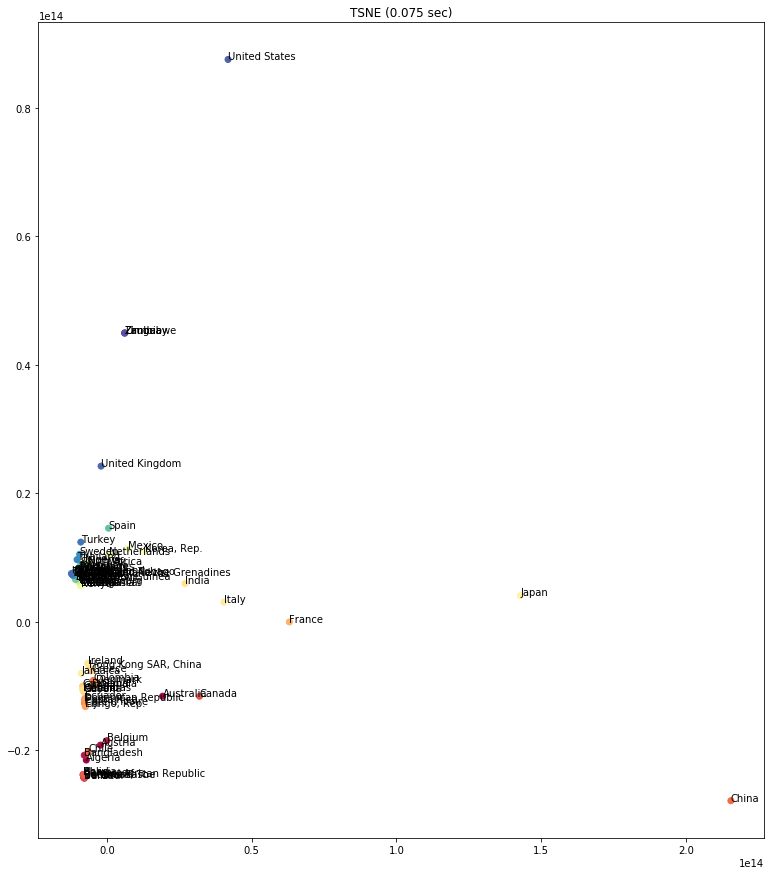

In [12]:

import matplotlib.pyplot as plt
from sklearn import manifold
from time import time

fig, ax = plt.subplots(figsize=(10,15))
t0 = time()
mds = manifold.TSNE(2, init='pca', random_state=0)
Y = mds.fit_transform(ds)
t1 = time()
color = [i for i in range(len(Y))]
ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("TSNE (%.2g sec)" % (t1 - t0))

for i, txt in enumerate(datas.index):
    ax.annotate(txt, (Y[i, 0], Y[i, 1]))
plt.show()

In [13]:
import pyximport; pyximport.install()
from frechet import frechet

In [14]:
P = datas.values[0].copy(order='C')
Q = datas.values[1].copy(order='C')
frechet(P, Q)

1.435204e+24

In [15]:
Y

array([[-7.1573669e+12, -2.1510876e+13],
       [ 1.9226073e+13, -1.1575206e+13],
       [-2.2570973e+12, -1.9185623e+13],
       [-8.0132393e+12, -2.4187987e+13],
       [-7.8517460e+12, -2.0765471e+13],
       [-1.9236594e+10, -1.8490386e+13],
       [-7.8143627e+12, -2.4338844e+13],
       [-7.9874459e+12, -2.4217249e+13],
       [-8.2909206e+12, -2.3779346e+13],
       [-8.0948342e+12, -2.4106016e+13],
       [-8.0484589e+12, -2.4166539e+13],
       [-7.8642109e+12, -2.4311595e+13],
       [-8.2161225e+12, -2.3829584e+13],
       [ 3.1954454e+13, -1.1587444e+13],
       [-7.7830312e+12, -2.3958525e+13],
       [-8.0070820e+12, -2.3790745e+13],
       [-6.5174624e+12, -2.0181949e+13],
       [ 2.1557432e+14, -2.7846437e+13],
       [-4.7422012e+12, -9.1230443e+12],
       [-7.4457762e+12, -1.3147954e+13],
       [-7.7325407e+12, -1.2549740e+13],
       [-7.7000616e+12, -1.2781669e+13],
       [-3.8053067e+12, -9.3594929e+12],
       [-7.7984878e+12, -1.2245951e+13],
       [-7.67197